# Analyse Chainer CIFAR nvprof metrics

```
In Docker container on DL:
root@3170abd9bd53:~/host# nvprof --csv --log-file chainer_768_all_metrics.csv --metrics all python chainer/examples/cifar/train_cifar.py -d cifar100 -g 0 -b 768 -e 1
```

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [25]:
log_file="logs/cifar_DLserv_nvprof_768_all_metrics.csv"

In [3]:
DF = pd.read_csv(log_file,skiprows=5)

In [4]:
DF.head()

,Device,Kernel,Invocations,Metric Name,Metric Description,Min,Max,Avg
0,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,sm_efficiency,Multiprocessor Activity,75.539221%,83.004431%,80.768809%
1,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,achieved_occupancy,Achieved Occupancy,0.150672,0.159779,0.156116
2,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,ipc,Executed IPC,2.673548,3.232274,2.941572
3,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,issued_ipc,Issued IPC,2.651608,3.185459,2.973647
4,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,inst_per_warp,Instructions per warp,7629.000000,7629.000000,7629.000000


In [5]:
dp_count = DF[DF["Metric Name"] == "flop_count_dp"]
print dp_count["Max"].unique()

['0' '393216' '122683392' '2359296']


In [6]:
dp_count = dp_count[pd.to_numeric(dp_count["Max"]) > 0]
dp_count.reset_index(inplace=True)
dp_count[["Device","Kernel","Invocations","Metric Name","Max","Avg","Min"]]

,Device,Kernel,Invocations,Metric Name,Max,Avg,Min
0,GeForce GTX TITAN X (0),void cudnn::detail::bn_bw_1CHW_kernel_new<floa...,66,flop_count_dp,393216,393216,393216
1,GeForce GTX TITAN X (0),"void gen_sequenced<curandStateXORWOW, double2,...",15,flop_count_dp,122683392,52082534,89856
2,GeForce GTX TITAN X (0),cupy_add,339,flop_count_dp,2359296,44318,0
3,GeForce GTX TITAN X (0),cupy_multiply,903,flop_count_dp,2359296,16637,0


In [15]:
DF.dtypes

Device                object
Kernel                object
Invocations            int64
Metric Name           object
Metric Description    object
Min                   object
Max                   object
Avg                   object
dtype: object

In [22]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if type(s) is not str:
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [23]:
DF[["Max","Avg","Min"]] = DF[["Max","Avg","Min"]].applymap(parseFloat)
DF.dtypes

Device                 object
Kernel                 object
Invocations             int64
Metric Name            object
Metric Description     object
Min                   float64
Max                   float64
Avg                   float64
dtype: object

In [24]:
DF.groupby(["Metric Name"]).agg({"Min":np.min, "Max":np.max, "Avg":np.mean})

,Max,Avg,Min
Metric Name,,,
achieved_occupancy,9.799430e-01,3.827888e-01,0.015605
atomic_transactions,1.474560e+05,1.852173e+03,0.000000
atomic_transactions_per_request,3.600000e+00,5.301892e-02,0.000000
branch_efficiency,1.000000e+02,9.963256e+01,88.888889
cf_executed,4.443341e+07,1.809054e+06,3.000000
cf_fu_utilization,2.000000e+00,1.019231e+00,1.000000
cf_issued,4.443341e+07,1.809054e+06,3.000000
double_precision_fu_utilization,9.000000e+00,2.307692e-01,0.000000
dram_read_throughput,9.674327e+02,1.139583e+02,1.293377


In [36]:
df_p = DF.groupby(["Metric Name"]).agg({"Min":np.min, "Max":np.max, "Avg":np.mean}).reset_index().pivot_table(columns="Metric Name",values=["Max","Avg","Min"])
df_p

Metric Name,achieved_occupancy,atomic_transactions,atomic_transactions_per_request,branch_efficiency,cf_executed,cf_fu_utilization,cf_issued,double_precision_fu_utilization,dram_read_throughput,dram_read_transactions,...,sysmem_write_throughput,sysmem_write_transactions,sysmem_write_utilization,tex_cache_hit_rate,tex_cache_throughput,tex_cache_transactions,tex_fu_utilization,tex_utilization,warp_execution_efficiency,warp_nonpred_execution_efficiency
Avg,0.382789,1852.173077,0.053019,99.632557,1.809054e+06,1.019231,1.809054e+06,0.230769,113.958315,1.755582e+06,...,131.030854,5.0,1.0,42.031168,201.589999,6.975305e+06,1.346154,1.134615,90.016003,85.500446
Max,0.979943,147456.000000,3.600000,100.000000,4.443341e+07,2.000000,4.443341e+07,9.000000,967.432715,5.110915e+07,...,697.662109,5.0,1.0,74.226804,934.310370,1.635779e+08,4.000000,4.000000,100.000000,100.000000
Min,0.015605,0.000000,0.000000,88.888889,3.000000e+00,1.000000,3.000000e+00,0.000000,1.293377,5.000000e+00,...,1.071431,5.0,1.0,0.000000,0.000000,0.000000e+00,1.000000,0.000000,3.024194,2.822581


In [44]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

<type 'dict'>


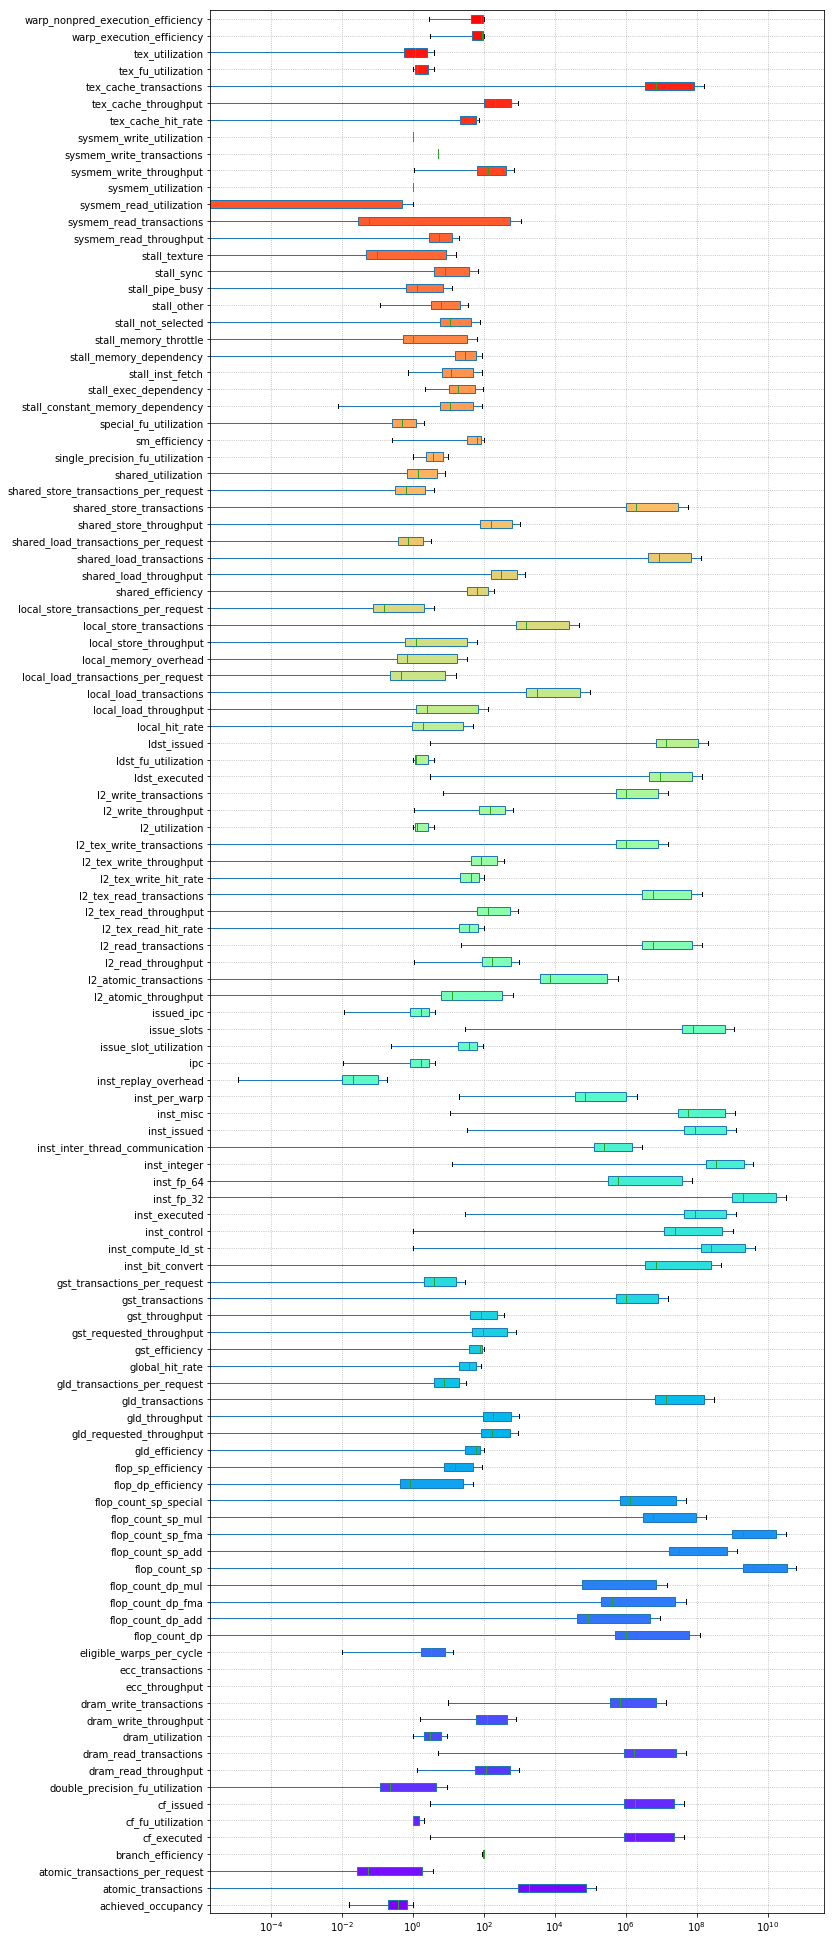

In [49]:
plt.rcParams['figure.figsize'] = 11,35
colors = getColorList("rainbow",114)
fig,ax = plt.subplots()
box = df_p.boxplot(vert=False,return_type="dict",patch_artist=True)
print type(box)
for bplot in box:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
ax.grid(ls=":")
ax.set_xscale("log")